In [1]:
import pandas as pd


In [2]:
df = pd.read_csv("dfAllData.csv", index_col=0)

In [8]:
df.columns

print("Columns in dfAllData.csv:")

df.columns

Columns in dfAllData.csv:


Index(['Study Title', 'Study URL', 'Acronym', 'Study Status', 'Brief Summary',
       'Study Results', 'Conditions', 'Interventions',
       'Primary Outcome Measures', 'Secondary Outcome Measures',
       'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Sex', 'Age',
       'Phases', 'Enrollment', 'Funder Type', 'Study Type', 'Study Design',
       'Other IDs', 'Start Date', 'Primary Completion Date', 'Completion Date',
       'First Posted', 'Results First Posted', 'Last Update Posted',
       'Locations', 'Study Documents', 'Target'],
      dtype='object')

In [6]:
df.shape

(6968, 30)

In [ ]:
selected_columns = [
    'Study Title', 
    'Brief Summary', 
    'Conditions', 
    'Interventions', 
    'Primary Outcome Measures', 
    'Sponsor', 
    'Collaborators', 
    'Sex', 
    'Age', 
    'Phases', 
    'Enrollment', 
    'Funder Type', 
    'Study Type', 
    'Study Design',
    'Target'  
]

df_selected = df[selected_columns].fillna('Unknown')

In [10]:
def create_prompt(row):
    prompt = (
        f"Study Title: {row['Study Title']}\n"
        f"Brief Summary: {row['Brief Summary']}\n"
        f"Condition: {row['Conditions']}\n"
        f"Intervention: {row['Interventions']}\n"
        f"Primary Outcome Measure: {row['Primary Outcome Measures']}\n"
        f"Sponsor: {row['Sponsor']}\n"
        f"Collaborators: {row['Collaborators']}\n"
        f"Sex: {row['Sex']}\n"
        f"Age: {row['Age']}\n"
        f"Phase: {row['Phases']}\n"
        f"Enrollment: {row['Enrollment']}\n"
        f"Funder Type: {row['Funder Type']}\n"
        f"Study Type: {row['Study Type']}\n"
        f"Study Design: {row['Study Design']}\n"
        "\nBased on the above information, predict if the clinical trial will fail (Completed without results). Answer Yes or No."
    )
    return prompt

# Apply
df_selected['prompt'] = df_selected.apply(create_prompt, axis=1)

In [15]:
print(df_selected["prompt"][0])

Study Title: Novel Biomarker for Development of T2D
Brief Summary: The investigators wants to determine if 11β-HSD1 activity will be positively associated, and 5α-reductase activity negatively associated, with (a) degree of insulin resistance defined by the homeostatic model assessment of insulin resistance index (HOMA-IR) and (b) worsening glycemic control defined by higher HbA1c and impaired fasting glucose in a group of obese children and young adults with or without type 2 diabetes compared to lean children and young adults without diabetes. The investigators also want to identify key metabolic signatures associated with diabetes using metabolomic profiling.
Condition: Diabetes Type II
Intervention: Unknown
Primary Outcome Measure: Relationship between 11β-HSD1 and 5α-reductase activity, and measures of insulin resistance, To assess the relationship between 11β-HSD1 and 5α-reductase activity, and measures of insulin resistance in a cohort of obese children with varying degrees of i

C:\Users\karan\AppData\Local\Temp\ipykernel_11024\1960260464.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_selected["prompt"][0])


In [ ]:
import requests
import time

GROQ_API_KEY = '##'


def query_groq(prompt):
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "llama3-8b-8192",  
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.2,  
        "max_tokens": 50     
    }
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        result = response.json()
        reply = result['choices'][0]['message']['content']
        return reply.strip()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None


In [ ]:
# Take a small random sample for testing
sample_df = df_selected.sample(100, random_state=42).reset_index(drop=True)

predictions = []
for prompt in sample_df['prompt']:
    reply = query_groq(prompt)
    print(f"Prompt:\n{prompt}\n\nResponse:\n{reply}\n{'-'*80}")
    predictions.append(reply)
    time.sleep(1)  # Sleep for 1 second between API calls to avoid rate limiting

sample_df['llm_response'] = predictions


Error 404: {"error":{"message":"The model `gpt-4-turbo` does not exist or you do not have access to it.","type":"invalid_request_error","code":"model_not_found"}}

Prompt:
Study Title: Efficacy and Safety of Oral Semaglutide Versus Liraglutide and Versus Placebo in Subjects With Type 2 Diabetes Mellitus
Brief Summary: This trial is conducted globally. The aim of this trial is to investigate efficacy and safety of oral Semaglutide versus Liraglutide and versus Placebo in Subjects with Type 2 Diabetes Mellitus.
Condition: Diabetes|Diabetes Mellitus, Type 2
Intervention: DRUG: semaglutide|DRUG: liraglutide|DRUG: placebo
Primary Outcome Measure: Change in HbA1c (Week 26), Change from baseline (week 0) in glycosylated haemoglobin (HbA1c) was evaluated at week 26. The endpoint was evaluated based on the data from the in-trial observation period, which was the time period from when a participant was randomised until the final scheduled visit, including any period after initiation of rescue me

In [34]:
def parse_response(response):
    if response is None:
        return -1
    response = response.lower()
    if 'yes' in response:
        return 1  # Predict Fail
    elif 'no' in response:
        return 0  # Predict Pass
    else:
        return -1  # Unable to parse


In [35]:
sample_df['predicted_label'] = sample_df['llm_response'].apply(parse_response)


In [36]:
# Convert Target column to integers
label_mapping = {'PASS': 0, 'FAIL': 1}
valid_df['true_label'] = valid_df['Target'].map(label_mapping)

# Now, both true_label and predicted_label are integers (0 or 1)


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(valid_df['true_label'], valid_df['predicted_label'])
precision = precision_score(valid_df['true_label'], valid_df['predicted_label'])
recall = recall_score(valid_df['true_label'], valid_df['predicted_label'])
f1 = f1_score(valid_df['true_label'], valid_df['predicted_label'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.2000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


d:\karan\interview task\siro\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:

few_shot_examples = [
    {
        'Study Title': 'Study of Drug X for Treatment of Diabetes',
        'Brief Summary': 'The study investigates Drug X for reducing blood sugar levels...',
        'Condition': 'Type 2 Diabetes',
        'Intervention': 'DRUG: Drug X',
        'Primary Outcome Measure': 'Reduction in HbA1c',
        'Sponsor': 'BigPharma Inc.',
        'Collaborators': 'University of ABC',
        'Sex': 'ALL',
        'Age': 'ADULT',
        'Phase': 'PHASE3',
        'Enrollment': '500',
        'Funder Type': 'INDUSTRY',
        'Study Type': 'INTERVENTIONAL',
        'Study Design': 'Randomized, Double Blind',
        'Result': 'PASS'
    },
    {
        'Study Title': 'Study of Compound Y in Patients with Diabetes',
        'Brief Summary': 'Compound Y failed to show improvements...',
        'Condition': 'Diabetes',
        'Intervention': 'DRUG: Compound Y',
        'Primary Outcome Measure': 'HbA1c reduction after 6 months',
        'Sponsor': 'SmallBioTech Co.',
        'Collaborators': 'None',
        'Sex': 'ALL',
        'Age': 'ADULT',
        'Phase': 'PHASE2',
        'Enrollment': '50',
        'Funder Type': 'OTHER',
        'Study Type': 'INTERVENTIONAL',
        'Study Design': 'Single-arm, Open Label',
        'Result': 'FAIL'
    }
]

def format_example(example):
    return (
        f"Study Title: {example['Study Title']}\n"
        f"Brief Summary: {example['Brief Summary']}\n"
        f"Condition: {example['Condition']}\n"
        f"Intervention: {example['Intervention']}\n"
        f"Primary Outcome Measure: {example['Primary Outcome Measure']}\n"
        f"Sponsor: {example['Sponsor']}\n"
        f"Collaborators: {example['Collaborators']}\n"
        f"Sex: {example['Sex']}\n"
        f"Age: {example['Age']}\n"
        f"Phase: {example['Phase']}\n"
        f"Enrollment: {example['Enrollment']}\n"
        f"Funder Type: {example['Funder Type']}\n"
        f"Study Type: {example['Study Type']}\n"
        f"Study Design: {example['Study Design']}\n"
        f"Result: {example['Result']}\n"
    )

few_shot_prompt = ""
for ex in few_shot_examples:
    few_shot_prompt += format_example(ex) + "\n"

def create_few_shot_prompt(row):
    new_trial = (
        f"Study Title: {row['Study Title']}\n"
        f"Brief Summary: {row['Brief Summary']}\n"
        f"Condition: {row['Conditions']}\n"
        f"Intervention: {row['Interventions']}\n"
        f"Primary Outcome Measure: {row['Primary Outcome Measures']}\n"
        f"Sponsor: {row['Sponsor']}\n"
        f"Collaborators: {row['Collaborators']}\n"
        f"Sex: {row['Sex']}\n"
        f"Age: {row['Age']}\n"
        f"Phase: {row['Phases']}\n"
        f"Enrollment: {row['Enrollment']}\n"
        f"Funder Type: {row['Funder Type']}\n"
        f"Study Type: {row['Study Type']}\n"
        f"Study Design: {row['Study Design']}\n"
        "\nPredict the Result (Answer exactly FAIL or PASS):"
    )
    return few_shot_prompt + "\n" + new_trial

# Apply
df_selected['few_shot_prompt'] = df_selected.apply(create_few_shot_prompt, axis=1)


In [45]:


def query_groq(prompt):
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "llama3-8b-8192",  # Still using llama3-8b
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.2,  # Low temperature = less randomness
        "max_tokens": 50      # Allow bigger output so it can explain
    }
    try:
        response = requests.post(url, headers=headers, json=data)
        if response.status_code == 200:
            result = response.json()
            reply = result['choices'][0]['message']['content']
            return reply.strip()
        else:
            print(f"Error {response.status_code}: {response.text}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None


In [46]:
# Small sample batch to test
sample_df = df_selected.sample(5, random_state=42).reset_index(drop=True)

predictions = []
for prompt in sample_df['few_shot_prompt']:
    reply = query_groq(prompt)
    print(f"Prompt:\n{prompt}\n\nResponse:\n{reply}\n{'-'*80}")
    predictions.append(reply)
    time.sleep(1)  # Be polite to GROQ API

sample_df['llm_response'] = predictions


Prompt:
Study Title: Study of Drug X for Treatment of Diabetes
Brief Summary: The study investigates Drug X for reducing blood sugar levels...
Condition: Type 2 Diabetes
Intervention: DRUG: Drug X
Primary Outcome Measure: Reduction in HbA1c
Sponsor: BigPharma Inc.
Collaborators: University of ABC
Sex: ALL
Age: ADULT
Phase: PHASE3
Enrollment: 500
Funder Type: INDUSTRY
Study Type: INTERVENTIONAL
Study Design: Randomized, Double Blind
Result: PASS

Study Title: Study of Compound Y in Patients with Diabetes
Brief Summary: Compound Y failed to show improvements...
Condition: Diabetes
Intervention: DRUG: Compound Y
Primary Outcome Measure: HbA1c reduction after 6 months
Sponsor: SmallBioTech Co.
Collaborators: None
Sex: ALL
Age: ADULT
Phase: PHASE2
Enrollment: 50
Funder Type: OTHER
Study Type: INTERVENTIONAL
Study Design: Single-arm, Open Label
Result: FAIL


Study Title: Efficacy and Safety of Oral Semaglutide Versus Liraglutide and Versus Placebo in Subjects With Type 2 Diabetes Mellitus
B

In [47]:
def parse_response(response):
    if response is None:
        return -1
    response = response.lower()
    if 'fail' in response:
        return 1  # Trial predicted to fail
    elif 'pass' in response:
        return 0  # Trial predicted to pass
    else:
        return -1  # Could not parse

sample_df['predicted_label'] = sample_df['llm_response'].apply(parse_response)


In [48]:
    # Convert true labels from text to 0/1
label_mapping = {'PASS': 0, 'FAIL': 1}
sample_df['true_label'] = sample_df['Target'].map(label_mapping)

# Filter valid rows
valid_df = sample_df[sample_df['predicted_label'] != -1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(valid_df['true_label'], valid_df['predicted_label'])
precision = precision_score(valid_df['true_label'], valid_df['predicted_label'])
recall = recall_score(valid_df['true_label'], valid_df['predicted_label'])
f1 = f1_score(valid_df['true_label'], valid_df['predicted_label'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.4000
Precision: 1.0000
Recall: 0.2500
F1 Score: 0.4000


In [49]:
# Sample 200 rows randomly
big_sample_df = df_selected.sample(200, random_state=42).reset_index(drop=True)


In [50]:
import time

predictions = []

for i, prompt in enumerate(big_sample_df['few_shot_prompt']):
    reply = query_groq(prompt)
    print(f"{i+1}: {reply}\n{'-'*60}")
    predictions.append(reply)
    time.sleep(1)  # Sleep for 1 second between calls


1: Based on the study design and primary outcome measure, I predict the result to be:

PASS
------------------------------------------------------------
2: Based on the study design and brief summary, I predict the result as:

FAIL
------------------------------------------------------------
3: Based on the study design and characteristics, I predict the result of the third study to be:

PASS
------------------------------------------------------------
4: Based on the study design and primary outcome measure, I predict the result to be:

PASS
------------------------------------------------------------
5: Based on the information provided, I predict the result of the third study as:

PASS

The study is an observational study, which means it is not an interventional study, and the primary outcome measure is assessing the incidence of serious adverse events, including
------------------------------------------------------------
6: Based on the study design and description, I predict the 

In [51]:
big_sample_df['llm_response'] = predictions


In [52]:
def parse_response(response):
    if response is None:
        return -1
    response = response.lower()
    if 'fail' in response:
        return 1
    elif 'pass' in response:
        return 0
    else:
        return -1

# Parse
big_sample_df['predicted_label'] = big_sample_df['llm_response'].apply(parse_response)


In [53]:
# Map 'PASS' to 0 and 'FAIL' to 1
label_mapping = {'PASS': 0, 'FAIL': 1}
big_sample_df['true_label'] = big_sample_df['Target'].map(label_mapping)


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Filter only valid predictions
valid_big_df = big_sample_df[big_sample_df['predicted_label'] != -1]

accuracy = accuracy_score(valid_big_df['true_label'], valid_big_df['predicted_label'])
precision = precision_score(valid_big_df['true_label'], valid_big_df['predicted_label'])
recall = recall_score(valid_big_df['true_label'], valid_big_df['predicted_label'])
f1 = f1_score(valid_big_df['true_label'], valid_big_df['predicted_label'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.5893
Precision: 0.8571
Recall: 0.5581
F1 Score: 0.6761


In [56]:
pip install wordcloud

  Using cached pillow-11.2.1-cp312-cp312-win_amd64.whl.metadata (9.1 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached pillow-11.2.1-cp312-cp312-win_amd64.whl (2.7 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 25.2 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Note: you may need to restart the kernel to use updated pack


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


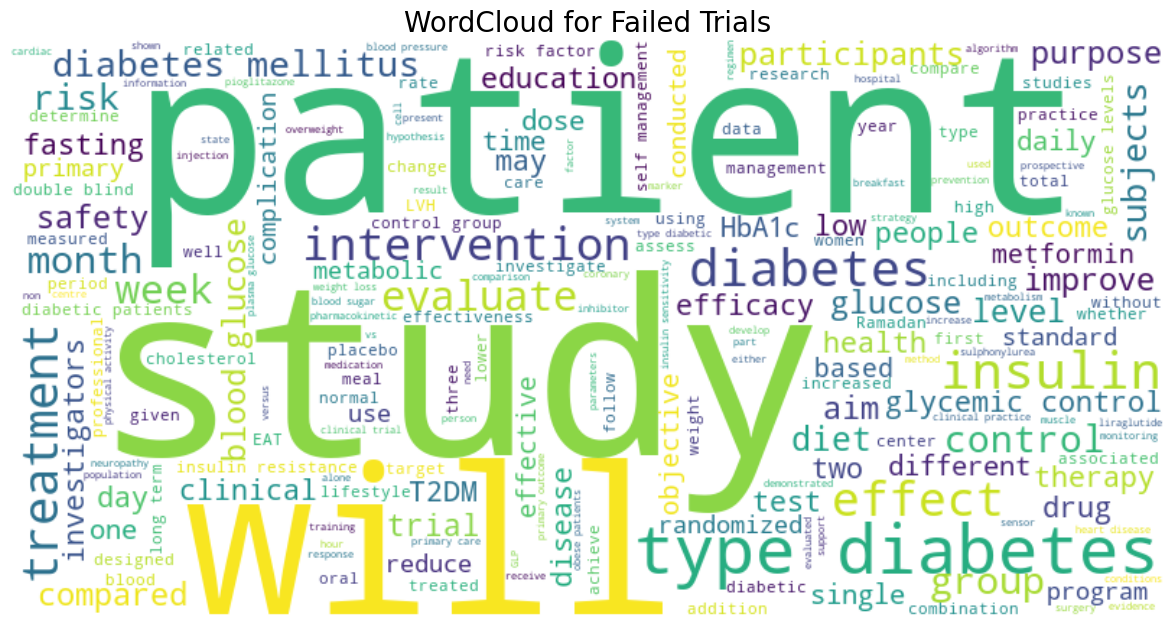

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Only take trials where true label is FAIL (1)
failed_trials = big_sample_df[big_sample_df['true_label'] == 1]

# Combine all brief summaries
text = " ".join(failed_trials['Brief Summary'].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Failed Trials', fontsize=20)
plt.show()
